# VonNeuman Stability of the Diffusion Equation

Consider the 1D diffusion equation:

$$\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2}$$

whose discretization is:

$$\frac{u_i^{n+1} - u_i^n}{\Delta t} = D \frac{u_{i-1}^n - 2u_{i}^n + u_{i+1}^n}{(\Delta x)^2}$$

Rearranging for the concentration at the future time step:

$$u_i^{n+1} = u_i^n + \frac{D\Delta t}{(\Delta x)^2}(u_{i-1}^n - 2u_{i}^n + u_{i+1}^n)$$.

We will set boundary conditions such that the concentration is zero at the boundaries, and the initial concentration profile is $u(x, 0) = sin(\pi x)$. In this particular computation, the Courant-Friedrichs-Lewy number is:

$$\alpha = \frac{D\Delta t}{(\Delta x)^2}$$

The numerical solution will be shown for two different values of $\alpha$.

In [45]:
def explicitDiffusion(nt, nx, L, T, D):
    import numpy as np
    dt = T/nt
    dx = L/nx
    alpha = D*dt/dx**2     # The CFL number
    
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    u = np.zeros((nx, nt))
    
    # Initial condition
    u[:, 0] = np.sin(np.pi*x)
    u[0, :] = 0
    u[-1, :] = 0
    
    for n in range(nt-1):
        un = np.copy(u)
        u[1:-1, n+1] = un[1:-1, n] + alpha * (un[:-2, n] - 2 * un[1:-1, n] + un[2:, n])
    return u, x, t, alpha

In [13]:
import matplotlib.pyplot as plt
import scipy 
from scipy import linalg
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

Text(0.5, 0.92, '$\\alpha$ = 0.505')

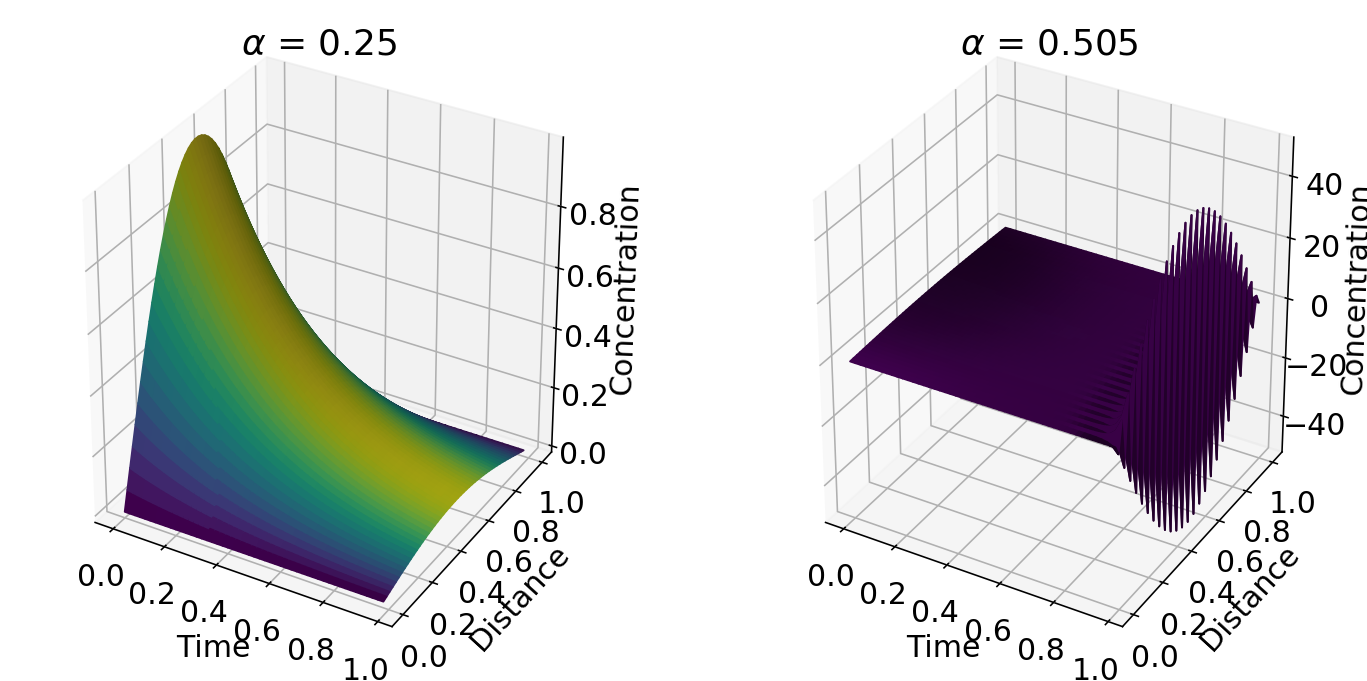

In [52]:
fig = plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

# CFL = 0.25
ax = fig.add_subplot(121, projection='3d')
u, x, t, alpha = explicitDiffusion(2500, 50, 1., 1., D=0.25)
T, X = np.meshgrid(t, x)
N = u/u.max()
ax.plot_surface(T[:,::50], X[:,::50], u[:,::50], facecolors=cm.viridis(N))
ax.set_xlabel('Time')
ax.set_ylabel('Distance')
ax.set_zlabel('Concentration')
ax.set_title(f'$\\alpha$ = {alpha}')

# CFL = 0.505
ax = fig.add_subplot(122, projection='3d')
u1, x1, t1, alpha1 = explicitDiffusion(2500, 50, 1., 1., D=0.505)
T1, X1 = np.meshgrid(t1, x1)
N1 = u1/u1.max()
ax.plot_surface(T1[:,::50], X1[:,::50], u1[:,::50], facecolors=cm.viridis(N1))
ax.set_xlabel('Time')
ax.set_ylabel('Distance')
ax.set_zlabel('Concentration')
ax.set_title(f'$\\alpha$ = {alpha1}')

The solution becomes unstable at higher values of $\alpha$. Looking at an x-y plane view of the solutions:

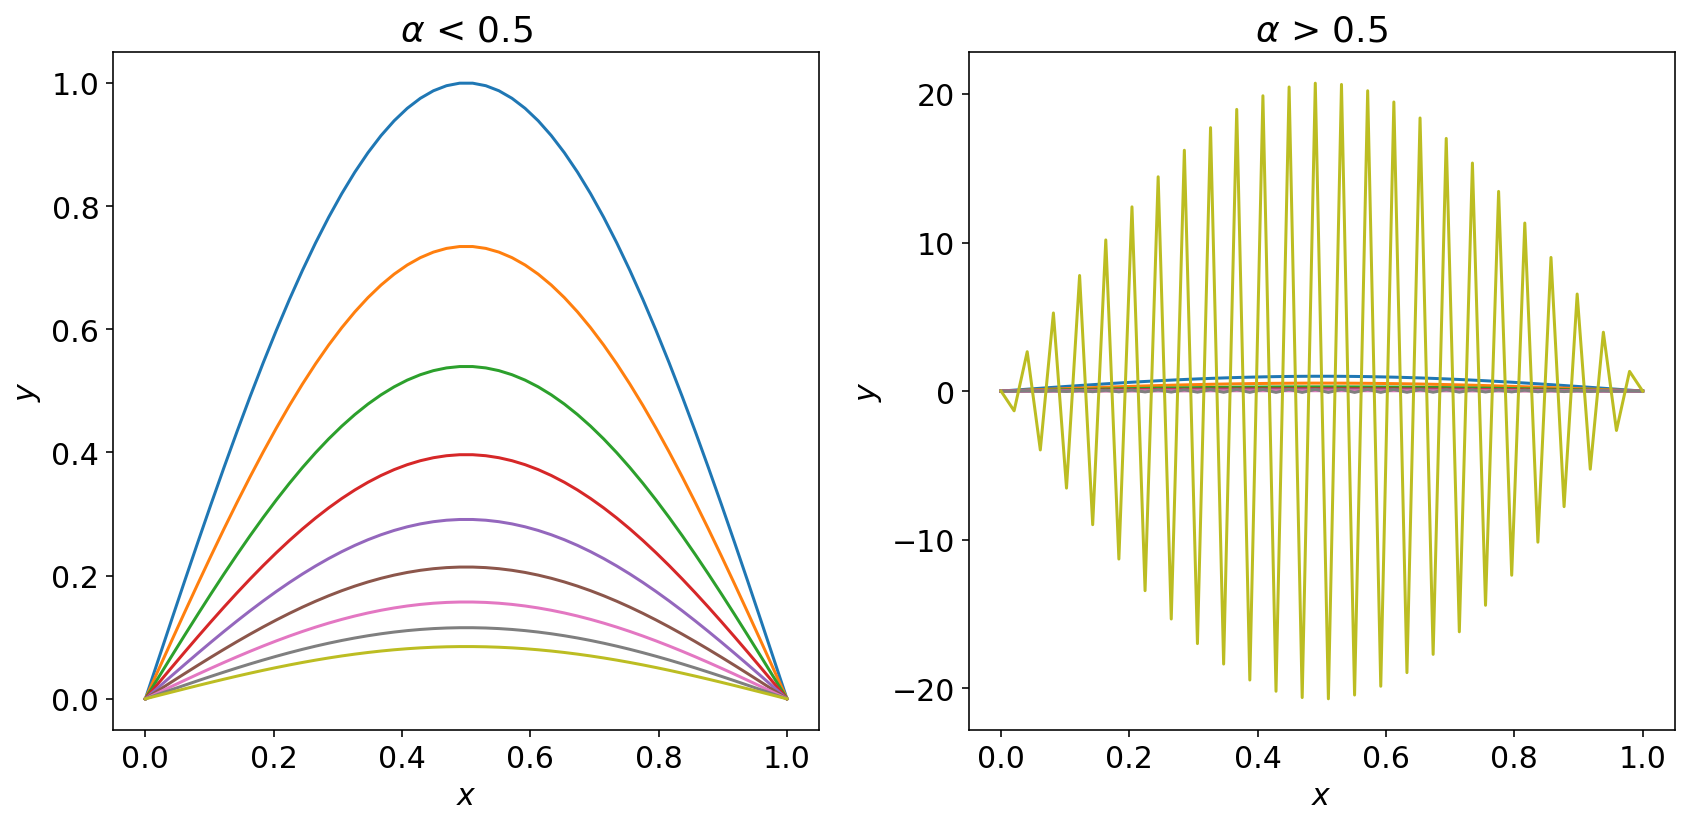

In [56]:
plt.figure(figsize=(12,6))
plt.subplot(121)
nt = 2500
for i in range(nt):
    if i%300 == 0:
        plt.plot(x, u[:, i])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$\alpha$ < 0.5')

plt.subplot(122)
for i in range(nt):
    if i%300 == 0:
        plt.plot(x1, u1[:, i])
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$\alpha$ > 0.5')
plt.rcParams['font.size'] = 15
plt.tight_layout()

For an explicit solution to the diffusion equation, the coefficient $\alpha$ must be less than 0.5, which is a value determined by assuming a Fourier expansion for the solution and taking the ratio of the solution one time step in the future divided by the solution at the current time step.

# Implicit solution

The implicit scheme uses a backward difference for the time derivative, and also uses the future time step in the spatial derivative:

$$\frac{u_i^{n} - u_i^{n+1} }{\Delta t} = D \frac{u_{i-1}^{n+1} - 2u_{i}^{n+1} + u_{i+1}^{n+1}}{(\Delta x)^2}$$

which gives:

$$u_i^n = -\alpha u_{i-1}^{n+1} + (1+2\alpha) u_i^{n+1}  -\alpha u_{i+1}^{n+1}$$

The boundary conditions provide 2 of the equations needed at $i=0, N$. The matrix form of the system is:

$$\begin{bmatrix} u_1^n \\ u_2^n \\ u_3^n \\ ... \\ u_{N_x-4}^n \\ u_{N_x-3}^n \\ u_{N_x-2}^n \end{bmatrix} =  \begin{bmatrix} 1+2\alpha && -\alpha && 0  && ... && 0 && 0 && 0 \\ -\alpha && 1+ 2\alpha && -\alpha && ... && 0 && 0 && 0 \\ 0 && -\alpha && 1+2\alpha && ... && 0 && 0 && 0 \\ ... && ... && ... && ... && ... &&... &&... \\ 0 && 0 && 0 && ... && 1+2\alpha && -\alpha && 0 \\ 0 && 0 && 0 && ... && -\alpha && 1+2\alpha && -\alpha \\ 0 && 0 && 0 && ... &&0 && -\alpha && 1+2\alpha \end{bmatrix}    \begin{bmatrix} u_1^{n+1} \\ u_2^{n+1} \\ u_3^{n+1} \\ ... \\ u_{N_x-4}^{n+1} \\ u_{N_x-3}^{n+1} \\ u_{N_x-2}^{n+1} \end{bmatrix} +  \begin{bmatrix} -\alpha u_0^{n+1} \\ 0 \\ 0 \\ ... \\ 0 \\0 \\ -\alpha u_{N_x-1}^{n+1} \end{bmatrix}$$

or, in short:

${\bf u}^n = {\bf M} {\bf u}^{n+1} + {\bf b}$

Here, the additional vector $\bf b$ is provided to supply the boundary conditions into the system. In the code below, the vector with the boundary conditions does not appear because the boundary conditions are zero.

In [62]:
def implicitDiffusion(nt, nx, L, T, D):
    dt = T/(nt-1)
    dx = L/(nx-1)
    alpha = D*dt/dx**2
    x = np.linspace(0, L, nx)
    t = np.linspace(0, T, nt)
    u = np.zeros((nx, nt))
    
    # Initial conditions
    u[:, 0] = np.sin(np.pi*x)
    
    # Boundary conditions
    u[0, :] = 0
    u[-1, :] = 0
    
    aa = -alpha*np.ones(nx-3)
    bb = (1+2*alpha)*np.ones(nx-2)
    cc = -alpha*np.ones(nx-3)
    M = np.diag(aa, -1) + np.diag(bb, 0) + np.diag(cc, 1)
    
    for k in range(1, nt):
        u[1:-1,k] = linalg.solve(M, u[1:-1, k-1])
        
    return u, x, t, alpha

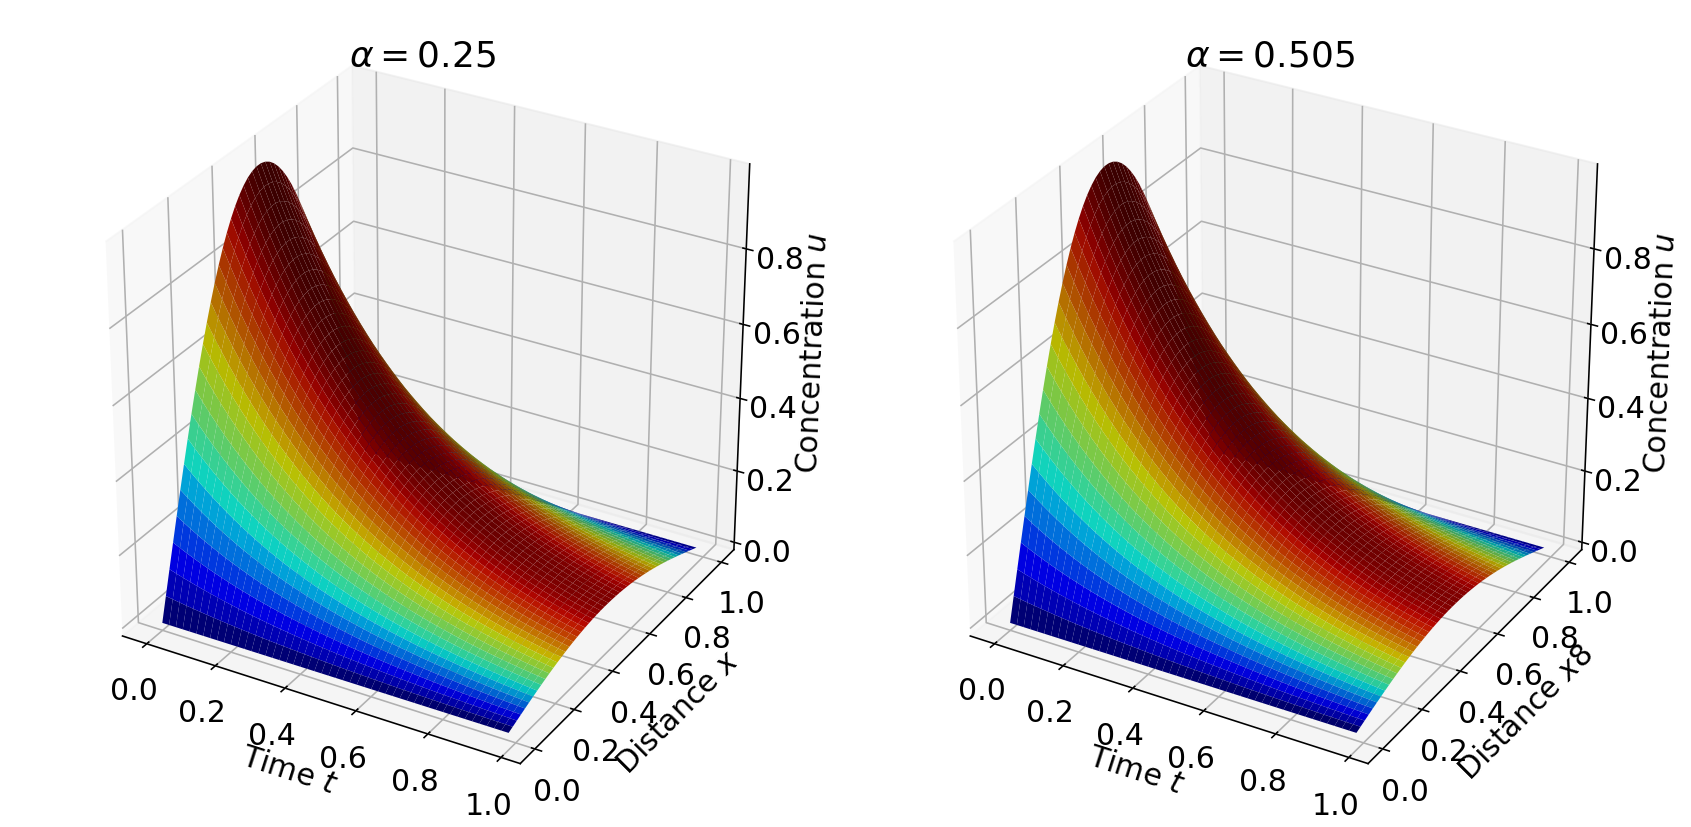

In [63]:
fig = plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

ax = fig.add_subplot(121, projection='3d')
ui, xi, ti, alphai = implicitDiffusion(nt = 2500, nx = 50, L= 1., T = 1., D = 0.25)
Ti, Xi = np.meshgrid(ti,xi)
N = ui/ui.max()
ax.plot_surface(Ti[:,::50], Xi[:,::50], ui[:,::50], linewidth=0, facecolors=cm.jet(N))
ax.set_xlabel('Time $t$')
ax.set_ylabel('Distance $x$')
ax.set_zlabel('Concentration $u$')
ax.set_title('$\\alpha = 0.25$')

ax = fig.add_subplot(122, projection='3d')
ui1, xi1, ti1, alphai1 = implicitDiffusion(nt = 2500, nx = 50, L= 1., T = 1., D = 0.25)
Ti1, Xi1 = np.meshgrid(ti1,xi1)
N = ui1/ui1.max()
ax.plot_surface(Ti1[:,::50], Xi1[:,::50], ui1[:,::50], linewidth=0, facecolors=cm.jet(N))
ax.set_xlabel('Time $t$')
ax.set_ylabel('Distance $x8$')
ax.set_zlabel('Concentration $u$')
ax.set_title('$\\alpha = 0.505$')
plt.tight_layout()

Performing the stability analysis will show that the implicit scheme is unconditionally stable. However, it requires matrix inversion, or at least some other form of solution (LU decomposition, etc). An  ill-conditioned matrix could affect the solution, as well. The solution process will be slower than the array operations that are available to the explicit scheme.